In [432]:
# thêm thư viện
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats.mstats import normaltest
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

In [433]:
# Đọc dữ liệu từ file CSV
data = pd.read_csv('Data/merged_data.csv')
data.head(5)

,Date,Price,Open,High,Low,Vol.,Change %,XSTC
0,2018-06-05,3592.5,3523.6,3631.8,3425.1,140590.0,4.89,AGR
1,2018-06-06,3612.1,3592.5,3631.8,3543.2,113340.0,0.55,AGR
2,2018-06-07,3641.7,3641.7,3651.5,3592.5,75800.0,0.82,AGR
3,2018-06-08,3562.9,3641.7,3641.7,3543.2,118030.0,-2.16,AGR
4,2018-06-11,3533.4,3562.9,3562.9,3444.8,82080.0,-0.83,AGR


In [434]:
data['Date'] = pd.to_datetime(data['Date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7450 entries, 0 to 7449
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      7450 non-null   datetime64[ns]
 1   Price     7450 non-null   float64       
 2   Open      7450 non-null   float64       
 3   High      7450 non-null   float64       
 4   Low       7450 non-null   float64       
 5   Vol.      7450 non-null   float64       
 6   Change %  7450 non-null   float64       
 7   XSTC      7450 non-null   object        
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 465.8+ KB


In [435]:
# Group by the 'XSTC' column
grouped_df = data.groupby('XSTC')

# Create a dictionary to hold each group as a separate dataframe
dataframes = {name: group for name, group in grouped_df}

In [436]:
def filter_XSTC(XSTC, date_index=True):
    df = dataframes[XSTC]
    df = df.sort_values(by='Date')
    if (date_index==False):
        df.reset_index(drop=True, inplace=True)
    else:
        df.set_index('Date', inplace=True)
    return df

In [437]:
AGR_df = filter_XSTC('AGR', date_index=True)
AGR_df

,Price,Open,High,Low,Vol.,Change %,XSTC
Date,,,,,,,
2018-06-05,3592.5,3523.6,3631.8,3425.1,140590.0,4.89,AGR
2018-06-06,3612.1,3592.5,3631.8,3543.2,113340.0,0.55,AGR
2018-06-07,3641.7,3641.7,3651.5,3592.5,75800.0,0.82,AGR
2018-06-08,3562.9,3641.7,3641.7,3543.2,118030.0,-2.16,AGR
2018-06-11,3533.4,3562.9,3562.9,3444.8,82080.0,-0.83,AGR
...,...,...,...,...,...,...,...
2024-05-15,19650.0,19150.0,20100.0,18950.0,3150000.0,3.15,AGR
2024-05-16,19700.0,20500.0,20500.0,19600.0,1650000.0,0.25,AGR
2024-05-17,20100.0,19700.0,20300.0,19400.0,2310000.0,2.03,AGR


## **1. Kiểm tra Stationarity**

**Stationarity**
- **Strict stationarity**: the joint distribution of any set of observations in the series remains the same regardless of the time at which the observations are taken.

- **Weak stationarity**: The mean is constant over time; The variance is finite; The covariance of $X(t)$ and $X(t+h)$ depends only on $h$, i.e., is shift-invariance in time.

**Dưới đây, ta kiểm tra tính chất weak stationarity của các time series. Một time series đạt weak stationarity cần thỏa mãn 4 tính chất liệt kê sau đây:**
- Constant mean (no trend). #1
- Constant variance (no heteroskedasticity). #2
- Constant autocorrelation structure (depend on the lag $h$ only). #3

**Để kiểm tra stationarity trong time series chúng ta kết hợp nhiều cách khác nhau. Dưới đây sẽ sử dụng 4 kỹ thuật bao gồm:**
- Run-sequence plots: Trực quan để dự đoán xu hướng, chu kỳ,...
- Summary statistics: Chia time series thành các chunk nhỏ để kiểm tra mean và variance.
- Histogram plots
- Augmented Dickey-Fuller test

#### **1.1. Ngân hàng AGRIBANK**

**Run-sequence plot**

In [486]:
def plot(series, series_name):
    # Compute rolling statistics
    rolmean = series.rolling(window=12).mean()
    rolstd = series.rolling(window=12).std()

    # Plot rolling statistics:
    plt.figure(figsize=(14, 4))
    plt.plot(series, color='tab:blue',label='Series')
    # plt.plot(rolmean, color='tab:red', label='Rolling Mean')
    plt.plot(rolstd, color='darkorange', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title(f'{series_name} Over Time with Rolling Mean and Standard Deviation')
    plt.grid(); 

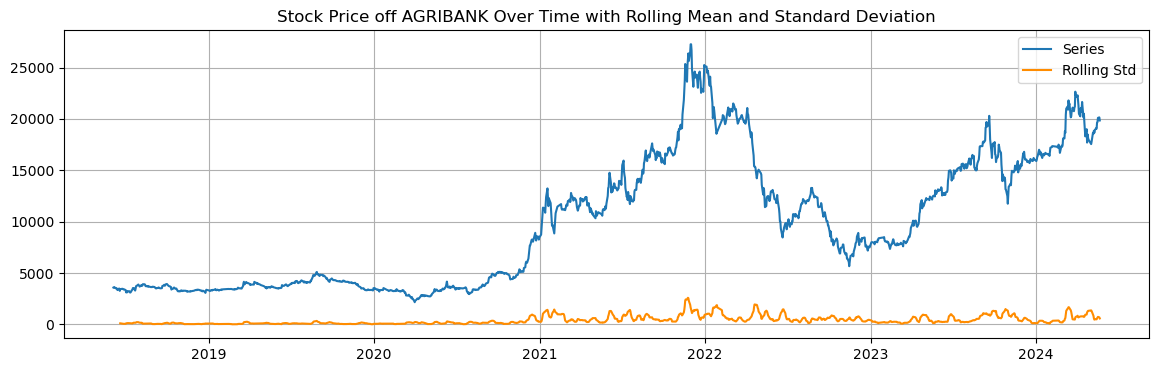

In [487]:
plot(series=AGR_df['Price'], series_name='Stock Price off AGRIBANK')

Dựa vào biểu đồ trực quan, ta có thể thấy:
- Time series có xu hướng (trend), vì mean thay đổi theo thời gian (vi phạm điều kiện #1).
- Phương sai thay đổi theo thời gian: trước năm 2021 phương sai nhỏ, nhưng sau năm 2021 thì phương sai lớn (vi phạm điều kiện #2).

**Summary Statistics**

In [440]:
def summary_statistics_price(series, series_name):
    print(f'Statistical Chunking Summary of {series_name} Stock Price')
    if len(series) >= 10:
        # Split data into 10 chunks
        chunks = np.array_split(series, 10)
        
        # Compare means and variances
        print("{}\t | {}\t\t | {}".format("Chunk", "Mean", "Variance"))
        print("-" * 35)
        for i, chunk in enumerate(chunks, 1):
            print("{:2}\t | {:.5}\t | {:.5}".format(i, np.mean(chunk), np.var(chunk)))
    else:
        print("Not enough data to split into 10 chunks")

In [441]:
summary_statistics_price(series=AGR_df['Price'], series_name='Stock Price off AGRIBANK')

Statistical Chunking Summary of Stock Price off AGRIBANK Stock Price
Chunk	 | Mean		 | Variance
-----------------------------------
 1	 | 3476.1	 | 4.8412e+04
 2	 | 3733.1	 | 8.0546e+04
 3	 | 3850.6	 | 3.2726e+05
 4	 | 3553.8	 | 5.5924e+05
 5	 | 9430.1	 | 7.6842e+06
 6	 | 1.6997e+04	 | 1.7443e+07
 7	 | 1.6262e+04	 | 2.4156e+07
 8	 | 8837.7	 | 3.5768e+06
 9	 | 1.3767e+04	 | 9.4157e+06
10	 | 1.7362e+04	 | 5.7454e+06


Dựa vào số liệu thống kê mô tả, ta thấy:
- Mean thay đổi theo thời gian (vi phạm điều kiện #1).
- Variance thay đổi theo thời gian (vi phạm điều kiện #2).

**Histogram Plot**

Nếu histogram gần với phân phối chuẩn thì ta có thể dự đoán mean và variance là không đổi theo thời gian.

In [442]:
def histogram_plot_price(series, series_name, ax=plt):
    ax.figure(figsize=(10, 6))
    ax.hist(series, bins=10, edgecolor='black')
    ax.title(f'Histogram of {series_name}')
    ax.xlabel('Price')
    ax.ylabel('Frequency')
    ax.grid(True)
    ax.show()

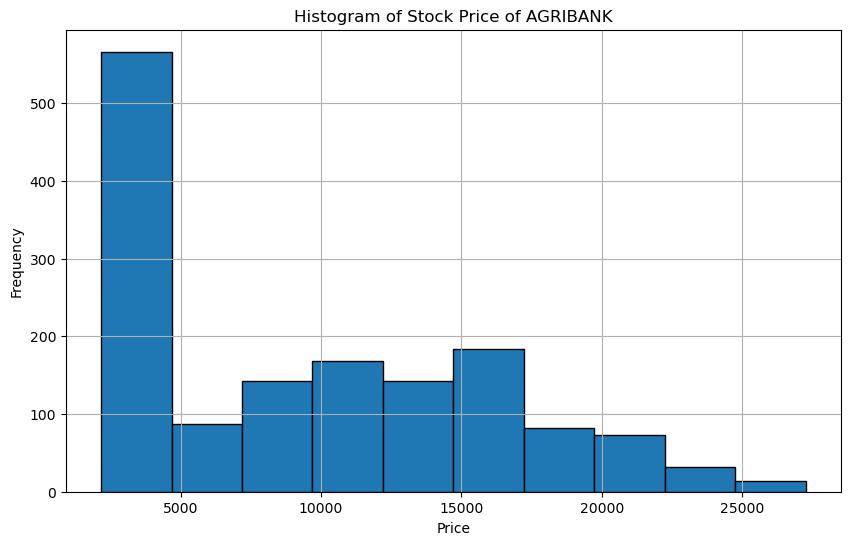

In [443]:
histogram_plot_price(series=AGR_df['Price'], series_name='Stock Price of AGRIBANK')

Chúng ta có thể sử dụng kiểm định thống kê để kiểm tra:

In [444]:
def normal_test(series, series_name, significance_level=0, prints=True):
    k2, pvalue = normaltest(series)

    # Print results if required
    if (prints == True):
        print(f"Normality Test Result for {series_name}:")
        print(f"Statistic: {k2:.4f}")
        print(f"P-value: {pvalue:.4f}")

        # Print conclusion if significance level is given
        if significance_level > 0:
            if (pvalue < significance_level):
                print(f"The null hypothesis of normality is REJECTED (significant level {significance_level}).")
            else:
                print(f"The null hypothesis of normality CANNOT BE REJECTED (significant level {significance_level}).")
    
    if (pvalue < significance_level): return "Rejected"
    else: return "Cannot be rejected"

In [445]:
_ = normal_test(series=AGR_df['Price'], series_name='Stock Price of AGRIBANK', significance_level=0.05, prints=True)

Normality Test Result for Stock Price of AGRIBANK:
Statistic: 202.2514
P-value: 0.0000
The null hypothesis of normality is REJECTED (significant level 0.05).


Do đó có thể kết luận được rằng time series trên không tuân theo phân phối chuẩn. Do đó, mean và variance của time series thay đổi theo thời gian (vi phạm điều kiện #1 và #2).

**Augmented Dickey-Fuller (ADF) Test**

- **Null hypothesis** $H_0$: the series is non-stationary.
- **Alternative hypothesis** $H_1$: the series is stationary.
> Chú ý: ADF test có thể không chính xác nếu dataset nhỏ hoặc trong trường hợp phương sai thay đổi (heteroskedasticity). Do đó cần kết hợp nhiều phương pháp bên cạnh ADF test.

In [446]:
def adf_test(series, series_name, significance_level=0, prints=True):
    adf, pvalue, _, _, critical_values, _ = adfuller(series, autolag='AIC')
    
    if (prints == True):
        print(f"ADF Test Result for {series_name}:")
        print("ADF Statistic:", adf)
        print("p-value:", pvalue)
        print("Critical values:", critical_values)

        if (significance_level > 0):
            if pvalue < significance_level:
                print(f"The null hypothesis of non-stationarity is REJECTED (significant level {significance_level}).")
            else:
                print(f"The null hypothesis of non-stationarity CANNOT BE REJECTED (significant level {significance_level}).")

    if (pvalue < significance_level): return "Rejected"
    else: return "Cannot be rejected"

In [447]:
_ = adf_test(series=AGR_df['Price'], series_name='Stock Price of AGRIBANK', significance_level=0.05, prints=True)

ADF Test Result for Stock Price of AGRIBANK:
ADF Statistic: -1.1787513632254543
p-value: 0.6826689057320126
Critical values: {'1%': -3.434815425568625, '5%': -2.8635121913888306, '10%': -2.567819976000063}
The null hypothesis of non-stationarity CANNOT BE REJECTED (significant level 0.05).


Kết quả của ADF test cho thấy ta không thể bác bỏ $H_0$, do đó time series là non-stationary.

**Vậy, time series về giá cổ phiếu `price` của ngân hàng AGRIBANK là non-stationary.**

#### **1.2. Đánh giá tổng quan tất cả các ngân hàng**

**Sub-sequence plots**

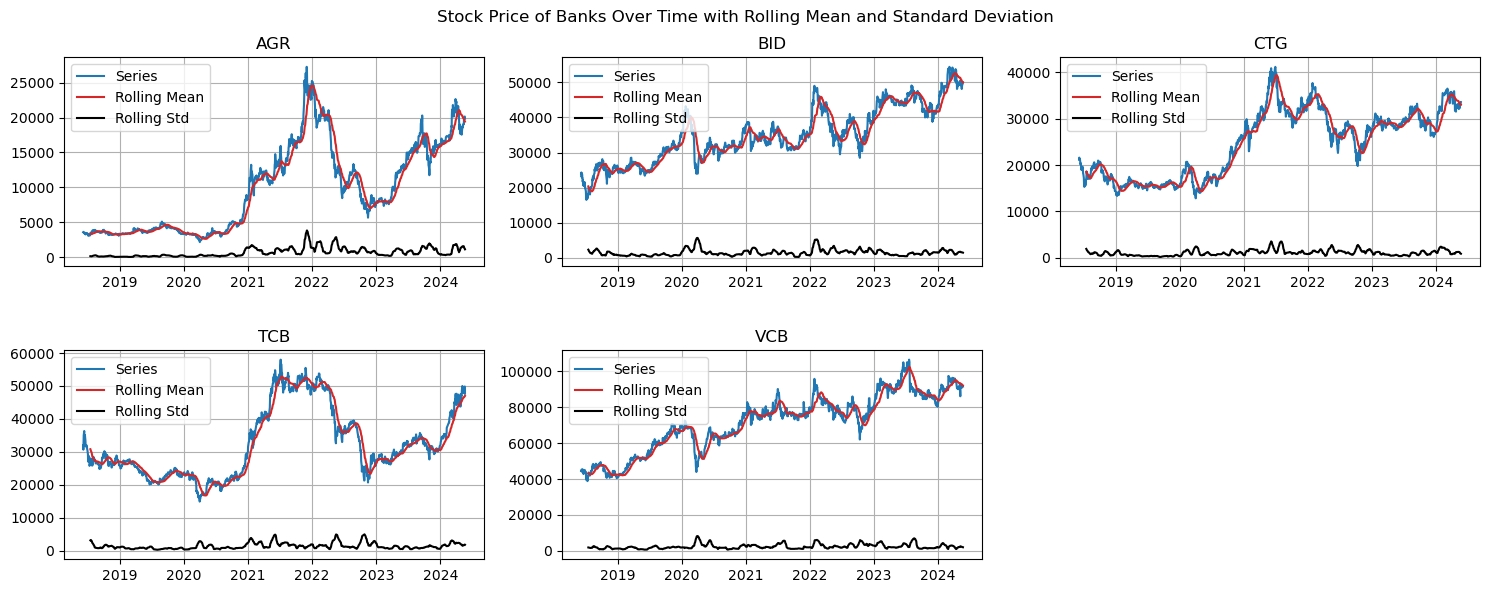

In [497]:
num_plots = len(dataframes)
cols = 3
rows = (num_plots + 1) // cols 

plt.figure(figsize=(15, 3 * rows))

for i, series_name in enumerate(dataframes.keys(), 1):
    series = filter_XSTC(series_name)['Price']

    plt.subplot(rows, cols, i)
    # Compute rolling statistics
    rolmean = series.rolling(window=30).mean()
    rolstd = series.rolling(window=30).std()

    # Plot rolling statistics:
    plt.plot(series, color='tab:blue',label='Series')
    plt.plot(rolmean, color='tab:red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title(series_name)
    plt.grid(); 

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.subplots_adjust(hspace=0.4)  
plt.suptitle('Stock Price of Banks Over Time with Rolling Mean and Standard Deviation')
plt.show()

**Histogram plots**

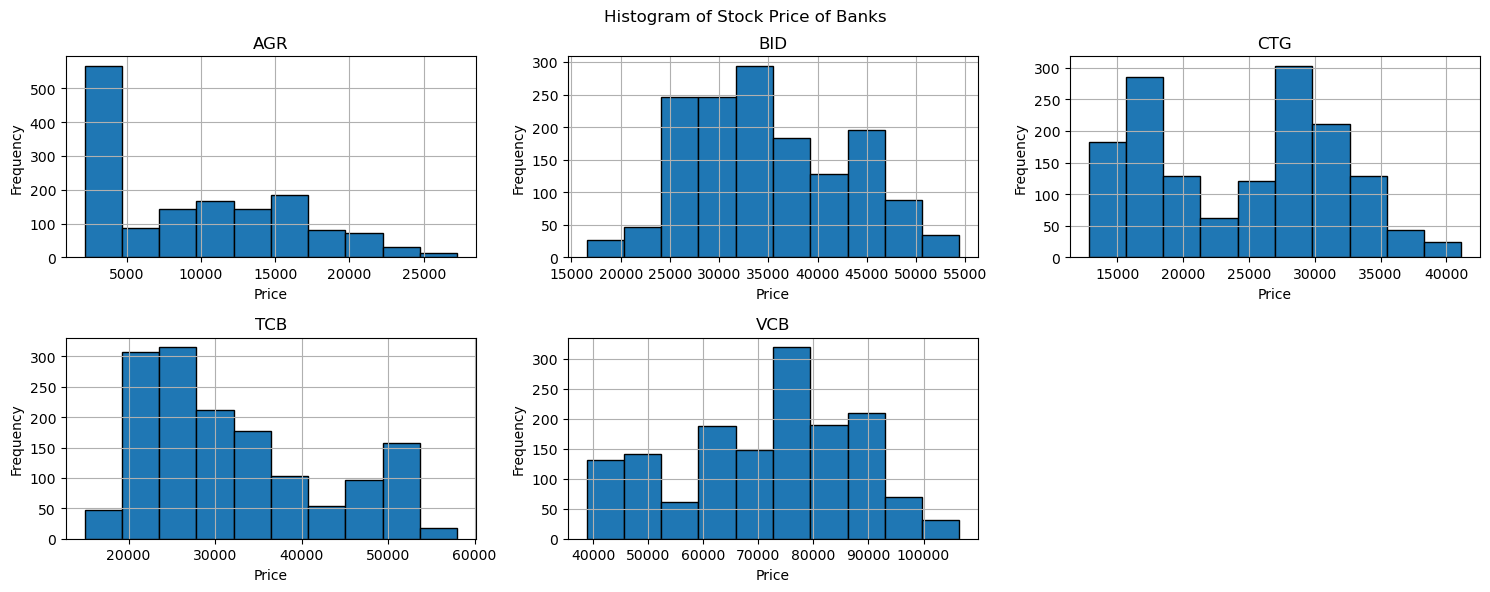

In [449]:
num_plots = len(dataframes)
cols = 3  
rows = (num_plots + 1) // cols 

plt.figure(figsize=(15, 3 * rows))

for i, series_name in enumerate(dataframes.keys(), 1):
    series = filter_XSTC(series_name)['Price']

    plt.subplot(rows, cols, i)
    plt.hist(series, bins=10, edgecolor='black')
    plt.title(series_name)
    plt.xlabel('Price')
    plt.ylabel('Frequency')
    plt.grid(True)


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.subplots_adjust(hspace=0.4)  
plt.suptitle('Histogram of Stock Price of Banks')
plt.show()

In [450]:
sig_level = 0.05
results = []

for series_name in dataframes.keys():
    series = filter_XSTC(series_name)['Price']
    normal_result = normal_test(series, series_name, significance_level=sig_level, prints=False)
    adf_result = adf_test(series, series_name, significance_level=sig_level, prints=False)
    results.append([series_name, normal_result, adf_result])

print(f"Normal Test and ADF Test Results for Stock Price (significant level {sig_level}):")
pd.DataFrame(results, columns=['Price Series', 'Normal', 'Non-stationary'])

Normal Test and ADF Test Results for Stock Price (significant level 0.05):


,Price Series,Normal,Non-stationary
0,AGR,Rejected,Cannot be rejected
1,BID,Rejected,Cannot be rejected
2,CTG,Rejected,Cannot be rejected
3,TCB,Rejected,Cannot be rejected
4,VCB,Rejected,Cannot be rejected


## **2. Prediction**

Ở đây ta sẽ dự đoán giá cổ phiếu cho ngân hàng BIDV (mã BID).

In [451]:
BID_df = filter_XSTC(XSTC='BID')
BID_df

,Price,Open,High,Low,Vol.,Change %,XSTC
Date,,,,,,,
2018-06-05,23266.4,23189.9,23878.7,22654.2,3860000.0,-0.33,BID
2018-06-06,24337.9,23304.7,24337.9,22807.2,3190000.0,4.61,BID
2018-06-07,23878.7,24337.9,24644.1,23878.7,4660000.0,-1.89,BID
2018-06-08,24108.3,23878.7,24261.4,23572.6,3370000.0,0.96,BID
2018-06-11,23725.6,23802.2,24452.7,23725.6,2920000.0,-1.59,BID
...,...,...,...,...,...,...,...
2024-05-15,48600.0,49000.0,49000.0,48100.0,1390000.0,1.04,BID
2024-05-16,48840.0,49200.0,50300.0,48600.0,2100000.0,0.49,BID
2024-05-17,49350.0,49750.0,50000.0,49200.0,1520000.0,1.04,BID


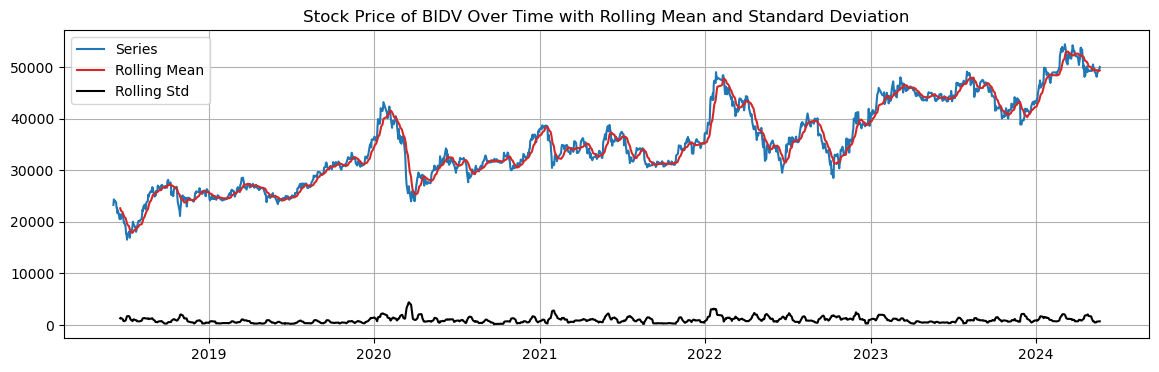

In [452]:
plot(series=BID_df['Price'], series_name='Stock Price of BIDV')

In [453]:
from scipy.fft import fft

def fft_analysis(signal):
    
    # Linear detrending
    slope, intercept = np.polyfit(np.arange(len(signal)), signal, 1)
    trend = np.arange(len(signal)) * slope + intercept 
    detrended = signal - trend 
    
    fft_values = fft(detrended)
    frequencies = np.fft.fftfreq(len(fft_values))

    # Remove negative frequencies and sort
    positive_frequencies = frequencies[frequencies > 0]
    magnitudes = np.abs(fft_values)[frequencies > 0]

    # Identify dominant frequency
    dominant_frequency = positive_frequencies[np.argmax(magnitudes)]
    print(f"Dominant Frequency: {dominant_frequency:.3f}")

    # Convert frequency to period (e.g., days, weeks, months, etc.)
    dominant_period = 1 / dominant_frequency
    print(f"Dominant Period: {dominant_period:.2f} time units")
    
    return dominant_period, positive_frequencies, magnitudes

period, freqs, magnitudes = fft_analysis(BID_df['Price'].values)
period = int(period)

Dominant Frequency: 0.003
Dominant Period: 298.00 time units


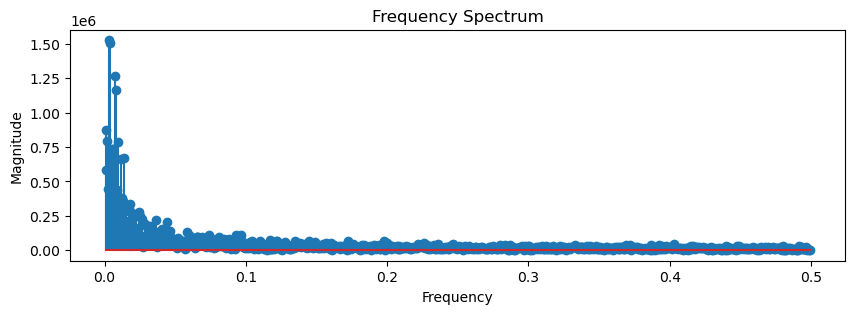

In [454]:
# Plotting the spectrum
plt.figure(figsize=(10, 3))
plt.stem(freqs, magnitudes)
plt.title('Frequency Spectrum')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.show()

In [455]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL

def seas_decomp_plots(original, decomposition):
    _, axes = plt.subplots(4, 1, sharex=True, sharey=False, figsize=(7, 5))
    axes[0].plot(original, label='Original')
    axes[0].legend(loc='upper left')
    axes[1].plot(decomposition.trend, label='Trend')
    axes[1].legend(loc='upper left')
    axes[2].plot(decomposition.seasonal, label='Seasonality')
    axes[2].legend(loc='upper left')
    axes[3].plot(decomposition.resid, label='Residuals')
    axes[3].legend(loc='upper left')
    plt.show()

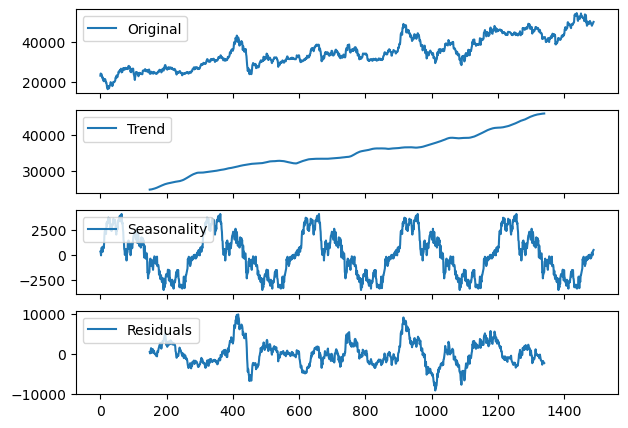

In [456]:
additive_decomposition = seasonal_decompose(x=BID_df['Price'].values, model='additive', period=period)
seas_decomp_plots(BID_df['Price'].values, additive_decomposition)

# Create DataFrame for decomposed components
add_decomposition_df = pd.DataFrame({
    'Trend': additive_decomposition.trend,
    'Seasonal': additive_decomposition.seasonal,
    'Residual': additive_decomposition.resid
}, index=BID_df.index)

BID_df['Add_residual'] = add_decomposition_df['Residual']

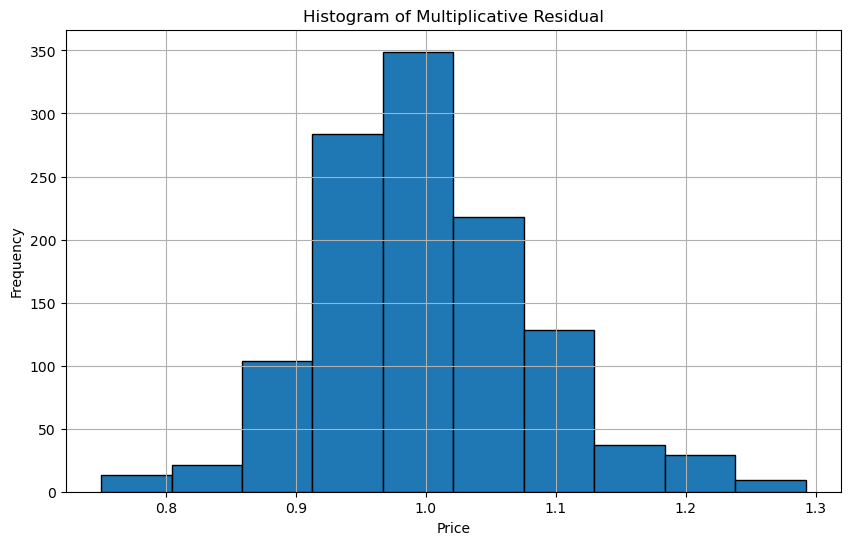

In [495]:
histogram_plot_price(BID_df['Mul_residual'], 'Multiplicative Residual')

In [496]:
normal_test(BID_df['Mul_residual'].dropna(), 'Multiplicative Residual', significance_level=0.05)

Normality Test Result for Multiplicative Residual:
Statistic: 43.3185
P-value: 0.0000
The null hypothesis of normality is REJECTED (significant level 0.05).


'Rejected'

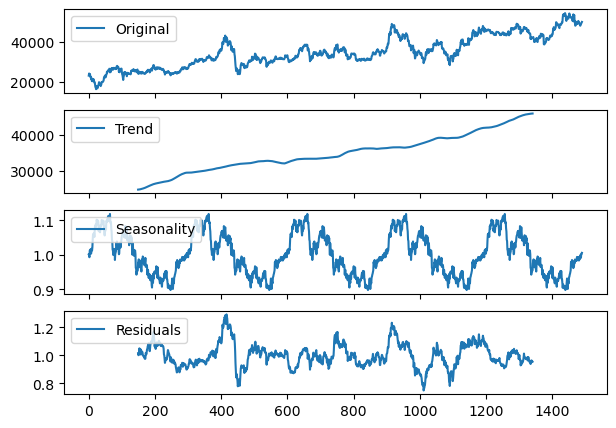

In [457]:
multiplicative_decomposition = seasonal_decompose(x=BID_df['Price'].values, model='multiplicative', period=period)
seas_decomp_plots(BID_df['Price'].values, multiplicative_decomposition)

mul_decomposition_df = pd.DataFrame({
    'Trend': multiplicative_decomposition.trend,
    'Seasonal': multiplicative_decomposition.seasonal,
    'Residual': multiplicative_decomposition.resid
}, index=BID_df.index)

BID_df['Mul_residual'] = mul_decomposition_df['Residual']

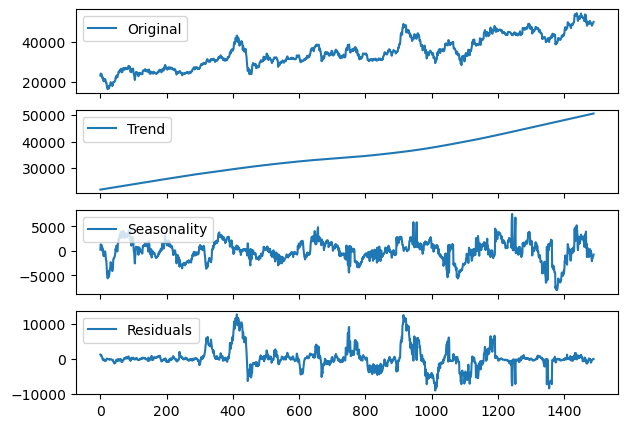

In [481]:
stl_decomposition = STL(endog=BID_df['Price'].values, period=period, robust=True).fit()
seas_decomp_plots(BID_df['Price'].values, stl_decomposition)

stl_decomposition_df = pd.DataFrame({
    'Trend': stl_decomposition.trend,
    'Seasonal': stl_decomposition.seasonal,
    'Residual': stl_decomposition.resid
}, index=BID_df.index)

BID_df['STL_residual'] = stl_decomposition_df['Residual']

Để áp dụng các mô hình ARMA cho mục đích dự đoán, ta cần phải đưa time series từ `non-stationary` về `stationary`. Một số các phương pháp đó là:

| Transformation       | Effect                 |
|----------------------|------------------------|
| Subtract trend       | Constant mean          |
| Apply log            | Constant variance      |
| Differencing         | Remove autocorrelation |
| Seasonal differencing| Remove periodic component|


In [459]:
# Perform log transformation
BID_df['Log'] = np.log(BID_df['Price'])
BID_df['Diff'] = BID_df['Price'].diff()
BID_df['Log_Diff'] = BID_df['Log'].diff()

BID_df

,Price,Open,High,Low,Vol.,Change %,XSTC,Add_residual,Mul_residual,STL_residual,Log,Diff,Log_Diff
Date,,,,,,,,,,,,,
2018-06-05,23266.4,23189.9,23878.7,22654.2,3860000.0,-0.33,BID,NaN,NaN,150.047017,10.054766,NaN,NaN
2018-06-06,24337.9,23304.7,24337.9,22807.2,3190000.0,4.61,BID,NaN,NaN,273.501972,10.099790,1071.5,0.045025
2018-06-07,23878.7,24337.9,24644.1,23878.7,4660000.0,-1.89,BID,NaN,NaN,-242.457661,10.080742,-459.2,-0.019048
2018-06-08,24108.3,23878.7,24261.4,23572.6,3370000.0,0.96,BID,NaN,NaN,-85.585452,10.090311,229.6,0.009569
2018-06-11,23725.6,23802.2,24452.7,23725.6,2920000.0,-1.59,BID,NaN,NaN,66.289002,10.074310,-382.7,-0.016002
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-15,48600.0,49000.0,49000.0,48100.0,1390000.0,1.04,BID,NaN,NaN,138.134247,10.791379,500.0,0.010341
2024-05-16,48840.0,49200.0,50300.0,48600.0,2100000.0,0.49,BID,NaN,NaN,-163.624606,10.796305,240.0,0.004926
2024-05-17,49350.0,49750.0,50000.0,49200.0,1520000.0,1.04,BID,NaN,NaN,131.012838,10.806693,510.0,0.010388


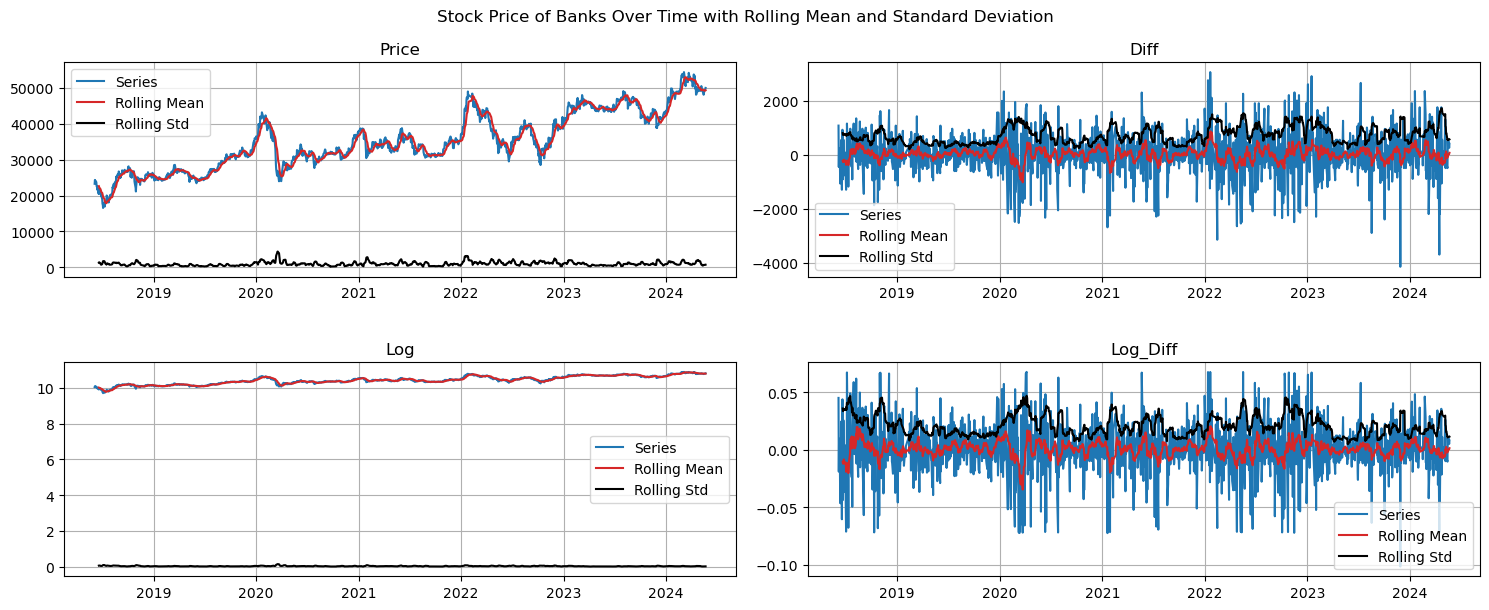

In [460]:
num_plots = len(dataframes)
cols = 2
rows = (num_plots + 1) // cols 

plt.figure(figsize=(15, 3 * rows))

# Filter out only the specified columns
BID_df_filtered = {key: BID_df[key] for key in ['Price', 'Diff', 'Log', 'Log_Diff']}

for i, (series_name, series) in enumerate(BID_df_filtered.items(), 1):
    plt.subplot(rows, cols, i)
    # Compute rolling statistics
    rolmean = series.rolling(window=12).mean()
    rolstd = series.rolling(window=12).std()

    # Plot rolling statistics:
    plt.plot(series, color='tab:blue',label='Series')
    plt.plot(rolmean, color='tab:red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title(series_name)
    plt.grid(); 

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.subplots_adjust(hspace=0.4)  
plt.suptitle('Stock Price of Banks Over Time with Rolling Mean and Standard Deviation')
plt.show()

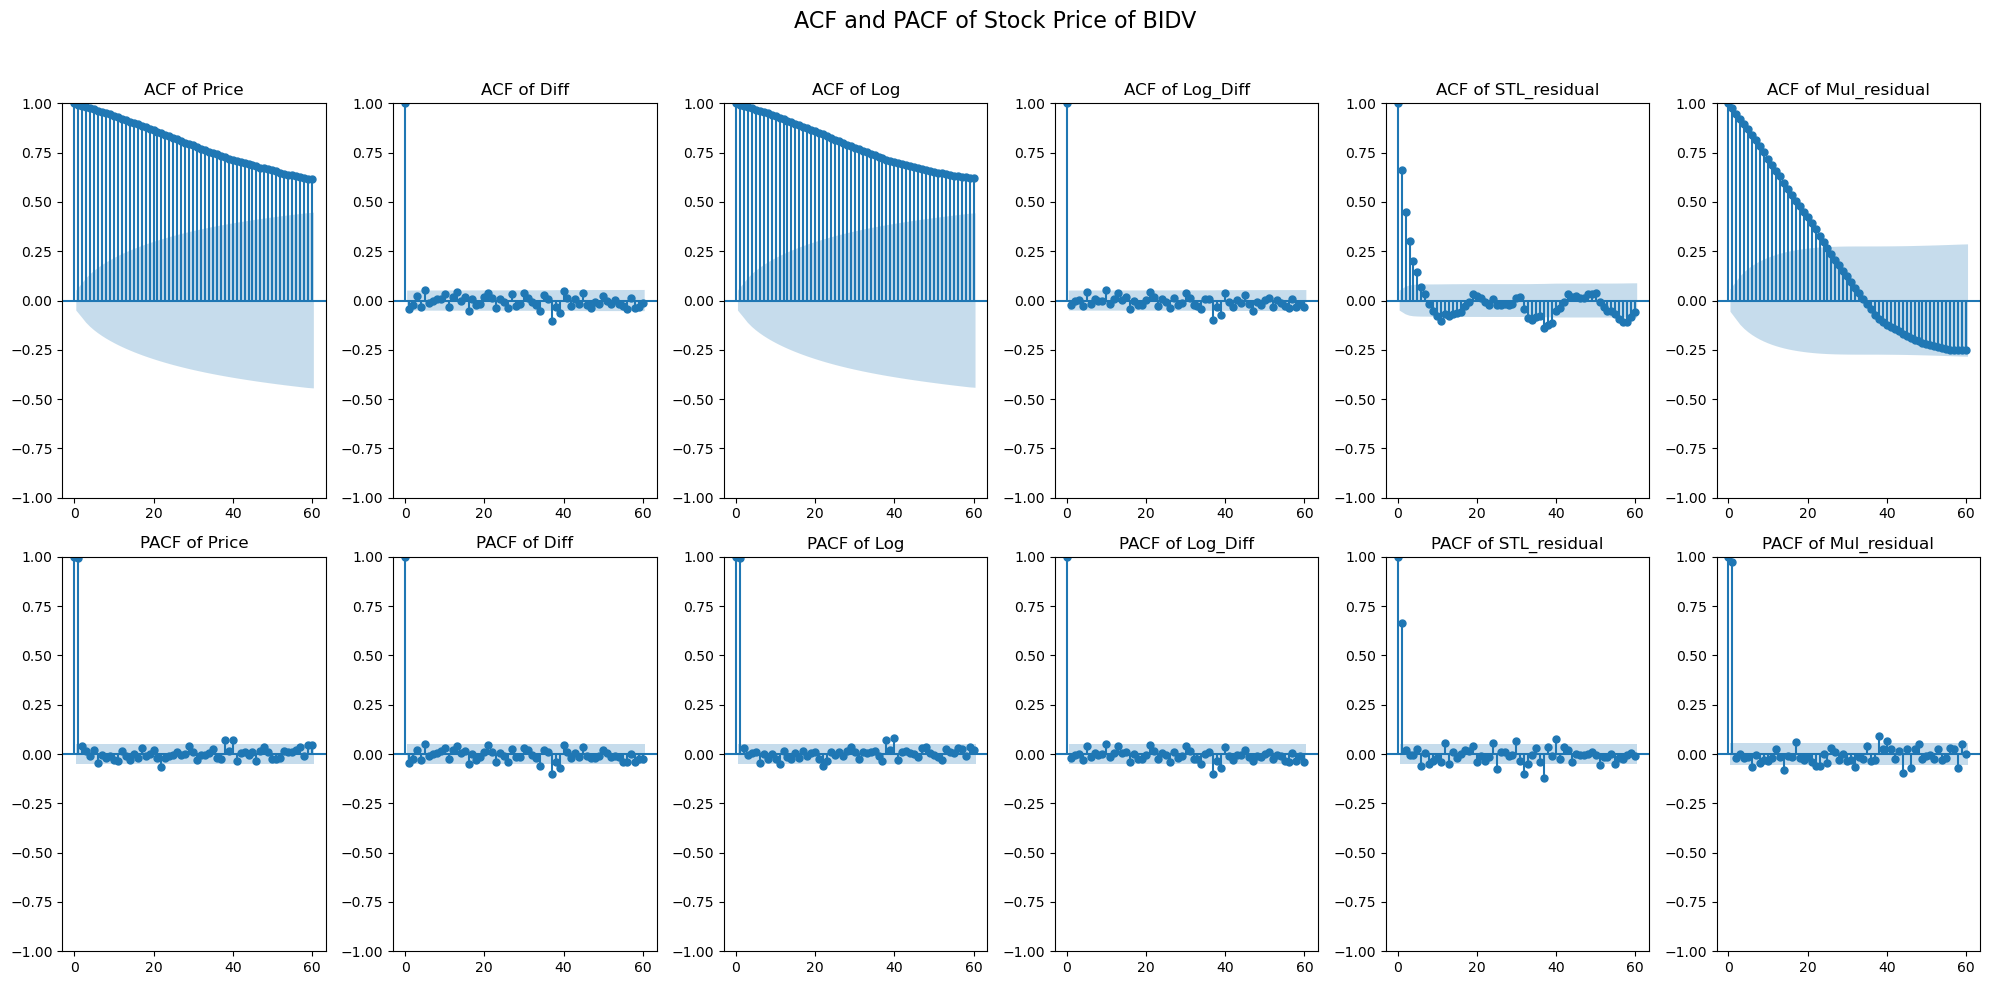

In [461]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Filter out only the specified columns
BID_df_filtered = {key: BID_df[key] for key in ['Price', 'Diff', 'Log', 'Log_Diff', 'STL_residual', 'Mul_residual']}

# Plot ACF and PACF for each series
fig, axes = plt.subplots(2, 6, figsize=(20, 10))  
fig.suptitle("ACF and PACF of Stock Price of BIDV", fontsize=16)

results_ = []
for i, (series_name, series) in enumerate(BID_df_filtered.items()):
    row = i // 6
    col = i
    series = series.dropna()

    normal_result = normal_test(series, series_name, significance_level=0.01, prints=False)
    adf_result = adf_test(series, series_name, significance_level=0.01, prints=False)
    results_.append([series_name, normal_result, adf_result])

    # Plot ACF
    plot_acf(series, ax=axes[row, col], lags=60)
    axes[row, col].set_title(f'ACF of {series_name}')

    # Plot PACF
    plot_pacf(series, ax=axes[row + 1, col], lags=60)
    axes[row + 1, col].set_title(f'PACF of {series_name}')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [462]:
print(f"Normal Test and ADF Test Results for Stock Price (significant level {sig_level}):")
pd.DataFrame(results_, columns=['Price Series', 'Normal', 'Non-stationary'])

Normal Test and ADF Test Results for Stock Price (significant level 0.05):


,Price Series,Normal,Non-stationary
0,Price,Rejected,Cannot be rejected
1,Diff,Rejected,Rejected
2,Log,Rejected,Cannot be rejected
3,Log_Diff,Rejected,Rejected
4,STL_residual,Rejected,Rejected
5,Mul_residual,Rejected,Rejected


In [463]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', ValueWarning)
import time
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels as ss
import seaborn as sns
from tqdm.notebook import tqdm
from scipy import stats
from scipy.fft import fft
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import mse
from statsmodels.tsa.statespace.tools import diff
import pmdarima as pm
np.random.seed(0)   

# Auto Arima

In [477]:
df = filter_XSTC(XSTC='BID', date_index=False)

In [479]:
from math import floor,ceil,sqrt
from pmdarima.arima import auto_arima

def auto_arima_prediction(df):
    shape=df.shape[0]
    df_new=df
    data = df_new.sort_index(ascending=True, axis=0)
    train_set=data[:ceil(shape*0.75)]
    valid_set=data[ceil(shape*0.75):]
    print('----------------------------------------------------------')
    print('-----------STOCK Close PREDICTION BY AUTO ARIMA-----------')
    print('----------------------------------------------------------')
    print('Shape of Training Set',train_set.shape)
    print('Shape of Validation Set',valid_set.shape)
    training = train_set['Price']
    validation = valid_set['Price']
    model = auto_arima(training, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True)
    model.fit(training)
    forecast = model.predict(n_periods=ceil(floor(df.shape[0]*0.25)))
    forecast = pd.DataFrame(forecast,index = valid_set.index,columns=['Prediction'])
    rms=np.sqrt(np.mean(np.power((np.array(valid_set['Price'])-np.array(forecast['Prediction'])),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')
    plt.plot(train_set['Price'])
    plt.plot(valid_set['Price'])
    plt.plot(forecast['Prediction'])
    plt.xlabel('Date',size=20)
    plt.ylabel('Stock Close',size=20)
    plt.title('Stock Close Prediction by Auto ARIMA',size=20)
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])


----------------------------------------------------------
-----------STOCK Close PREDICTION BY AUTO ARIMA-----------
----------------------------------------------------------
Shape of Training Set (1118, 8)
Shape of Validation Set (372, 8)
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=3.41 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=18565.592, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=18239.031, Time=1.81 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.83 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=18566.560, Time=0.10 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=18127.778, Time=3.13 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=5.67 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.93 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=18126.015, Time=0.65 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=18237.053, Time=0.38 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=3.58 s

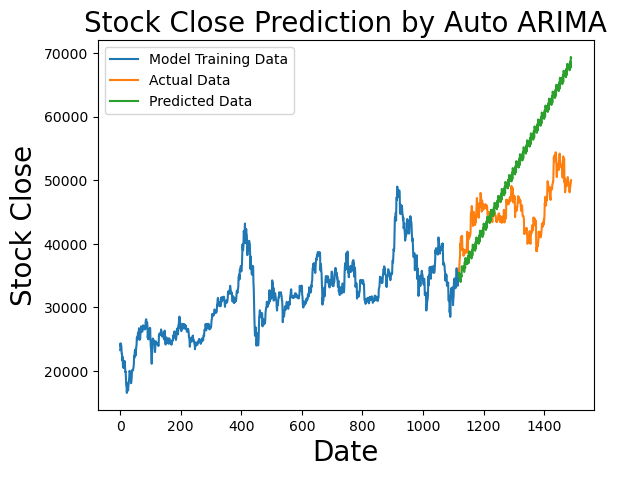

In [480]:
auto_arima_prediction(df)

### Long Short Term Memory

In [ ]:
# pip install TensorFlow

In [ ]:
# pip install tf_keras

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tf_keras.models import Sequential
from tf_keras.layers import Dense, LSTM
from math import ceil, sqrt

def lstm_prediction(df):
    shape = df.shape[0]
    df_new = df[['Price']]
    
    # Ensure that there are enough data points
    if shape < 40:
        print("Not enough data to train the model. Need at least 40 data points.")
        return
    
    dataset = df_new.values
    train = df_new[:ceil(shape * 0.75)]
    valid = df_new[ceil(shape * 0.75):]
    
    print('-----------------------------------------------------------------------------')
    print('-----------STOCK PRICE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)-----------')
    print('-----------------------------------------------------------------------------')
    print('Shape of Training Set:', train.shape)
    print('Shape of Validation Set:', valid.shape)
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    
    x_train, y_train = [], []
    for i in range(40, len(train)):
        x_train.append(scaled_data[i-40:i, 0])
        y_train.append(scaled_data[i, 0])
    
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(LSTM(units=50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)
    
    inputs = df_new[len(df_new) - len(valid) - 40:].values
    inputs = inputs.reshape(-1, 1)
    inputs = scaler.transform(inputs)
    
    X_test = []
    for i in range(40, inputs.shape[0]):
        X_test.append(inputs[i-40:i, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    closing_price = model.predict(X_test)
    closing_price = scaler.inverse_transform(closing_price)
    
    rms = sqrt(np.mean(np.power((valid.values - closing_price), 2)))
    print('RMSE value on validation set:', rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')
    
    valid['Predictions'] = closing_price
    plt.figure(figsize=(16, 8))
    plt.plot(train['Price'], label='Train')
    plt.plot(valid['Price'], label='Valid')
    plt.plot(valid['Predictions'], label='Prediction')
    plt.xlabel('Date', size=20)
    plt.ylabel('Stock Price', size=20)
    plt.title('Stock Price Prediction by Long Short Term Memory (LSTM)', size=20)
    plt.legend()
    plt.show()

-----------------------------------------------------------------------------
-----------STOCK PRICE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)-----------
-----------------------------------------------------------------------------
Shape of Training Set: (1118, 1)
Shape of Validation Set: (372, 1)
1078/1078 - 12s - loss: 0.0032 - 12s/epoch - 11ms/step
12/12 [==============================] - 1s 6ms/step
RMSE value on validation set: 1373.070578682687
-----------------------------------------------------------
-----------------------------------------------------------


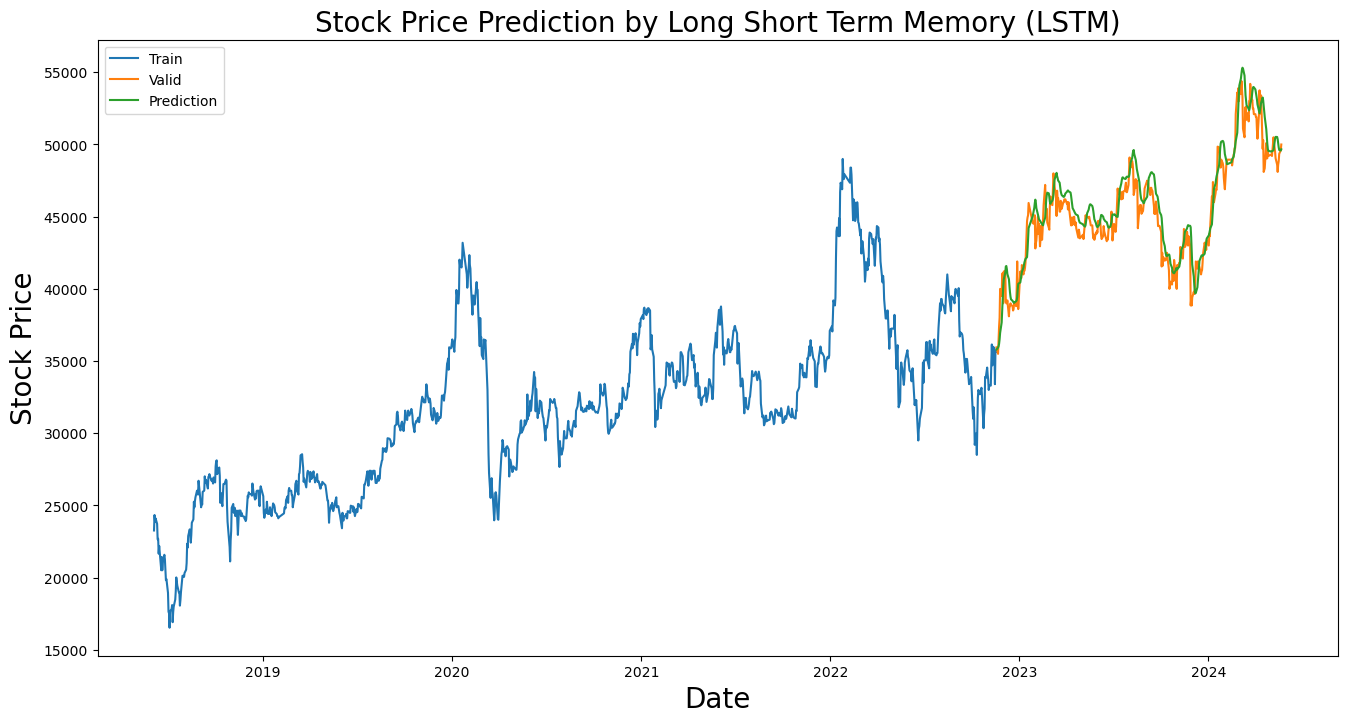

In [ ]:
lstm_prediction(BID_df)